# Credit Card Default Analysis
This notebook will be dedicated to analyzing credit card records from payments in Taiwan using logistic regression and comparing various models. Logistic regression can be seen as the building block of neural networks, so a good fundamental understanding of this basic model will help the reader better understand neural nets and how they can optimize their performance. To do this, I will go from a basic model to using under and over-sampling techniques with regularization techniques to optimize model performance. 

This is not a short read, so please feel free to skip to the section you care about. Here's a TLDR for the time-starved: 
- Imbalanced datasets can cause big headaches, so it's worth it to manipulate your data to achieve a better balance.
- ML practitioners should experiment with different models.
- Optimizing models for the wrong measurement (e.g. Accuracy instead of F1 score) will get you nowhere fast.
- Logistic regression is a great preprocessing tool to help you get a good feel for the dataset before training large and complicated neural nets, so get comfortable with them.

The dataset I am using in this project is aimed at the case of customer default payments in Taiwan (Yeh and Lien, 2006) and compares the predictive accuracy of probability of default among data mining methods, with explanations of each step required to go from the imported data to data that can be used to classify defaults. For classification, I start by applying simple classification algorithms to the problem and assessing their accuracy using various performance metrics, including accuracy, precision, recall, and a ROC curves, when needed. This will conclude the first portion of this project, as this will tell how accurate traditional methods of classification are when trying to predict credit card defaults within this dataset.

From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. While initial results from training l1 and l2 logistic regression models on the imbalanced dataset were not satisfactory, which I am attributing to the imbalance of outcomes within the dataset, I address this problem by optimizing for recall within Sci-kit learn's 'GridsearchCV' module, and using under and over-sampling techniques from the python package "imblearn". I assess and compare the performance metrics among the original, under, and over-sampled models, with results indicating that both over and under-sampling improve the recall rates for predicting credit card defaults by an equivalent amount.

While I was able to maximize the recall rates by using under and over-sampling techniques, the precision rates dropped significantly. For the purpose of this project and the context of this notebook, I will conclude with a statement about optimality of precision and how to proceed.

## Table of Contents
1. Data Wrangling and Explanations of Dataset Attributes
2. Data Story
3. Inferential Statistics
4. Basic Logistic Regression and Evaluation
5. GridsearchCV to Optimize l1 and l2 Logistic Regression, and Evaluation
6. Oversampling and Undersampling Methods on Logistic Regression, and Evaluation
7. Conclusions & Summary of Findings

# 1. Data Wrangling and Explanations of Dataset Attributes
The data contain the following attributes:

## Attribute Information:

The dataset employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. The study used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = other). 
- X4: Marital status (1 = married; 2 = single; 3 = other). 
- X5: Age (year). 
- X6 - X11: History of past payment. They tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = duly paid; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 

I'll now load the appropriate packages for later use and load the dataset to begin cleaning and wrangling.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from pandas.io.json import json_normalize
import seaborn as sns
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve
import scipy.stats as stats

In [2]:
defaults_df = pd.DataFrame.from_csv('default_of_credit_card_clients.csv')
defaults_df.shape

# Getting rid of first line mistake
new_header = defaults_df.iloc[0]
defaults_df = defaults_df[1:]
defaults_df.rename(columns = new_header)

#Renaming columns
new_header = list(new_header)
new_header[-1] = 'Y'
defaults_df.columns = new_header

# Changing to numeric, since data was imported as string objects
defaults_df = defaults_df.apply(pd.to_numeric)

# Removing false education values
defaults_df = defaults_df[defaults_df.EDUCATION != 0]

print(defaults_df.shape)
defaults_df.head()

(29986, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# Checking if any rows are blank.
defaults_df.shape[0] - defaults_df.dropna().shape[0]

0

In [4]:
# Missing/Null values?
defaults_df.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

After running some code to determine how much of the imported dataset was null or not, I found out that none of the columns had missing values. That doesn't mean there are no null values, it just means there are no values that I need to concern myself with, with regards to coverting from NULL or NaN to some logical value (average, median, regressed, etc.). 

## One-hot encoding
One-hot encoding is useful in python to help train any type of model that contains categorical features. One-hot encoding works by encoding variables that take categorical values, as combinations of binary variables representing the occurence of each possible unique categorical value for that variable. In this case, there are 9 different features that contain categorical values. Within those columns, there are varying options for distinction, such as sex having 2 options and history of past payment having 10 different values. One-hot encoding will split each of these columns into columns that have one category in the column, and whether or not that value is present in the row. Going back to the 'sex' category, this will split it into two columns called: "SEX_male" and "SEX_female", each of which will only contain binary variables.

To do this, I will use pandas to mutate the dataframe into something that is ready to use for ML algorithms.

In [5]:
clf_df = pd.get_dummies(defaults_df, columns=["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"],
               prefix=["SEX", "EDU", "MARRY", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"])
clf_df.shape

(29986, 91)

Created about 80 new columns that are one-hot encodings, which can be thought of as permutations of all the unique values in the categorical columns.

# 2. Data Story
In 2006, Taiwan faced a credit crisis that came to a head in the third quarter of 2006. This all started with banks over-issuing cash and credit to unqualified applicants and was catalyzed by many cardholders, irrespective of their repayment ability, overusing their credit cards for consumption, accruing heavy credit and cash-card debts. This crisis warranted more thorough investigation into improved techniques for assessing the probability of default by each individual consumer.

The dataset that is used in this project has been collected by Yeh and Lien (see the reference at the end of this notebook), and consists of "payment data in October, 2005, from an important bank in Taiwan. In summary, there are 23 features of the dataset that can be explored to get a better understanding of the information provided. Some features are time-series related information, such as the history of past payments, amount of bill statements in NT dollars, and the amount of previous payments. These are abstract concepts and, while they may be informative on their own for a machine learning model, they are quite hard to understand as they are right now, separated by columns for each individual. To rectify this issue, I will construct visualizations that show where the state of the Taiwan economy is from April to September of 2015, by each individual.

To do this, I'll construct a parallel coordinates graph for three sets of data: History of past payment (X6-X11), amount of bill statement (X12-X17), and amount of previous payment (X18-X23). Parallel coordinate graphs are especially useful for visualizing trends in clustered or labeled data, but since this dataset is on a continuous scale, I'll start by just observing overall trends.

In [6]:
# Loading relevant packages for data story
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
init_notebook_mode(connected=True)

You'll notice that I am using Plot.ly's graphing package for this job. While matplotlib, seaborn, d3.js, and other graphing packages are great, they have various limitations, including the ability to graph parallel coordinate plots, easily. While plotly can make some really stellar graphics, I've noticed that, when trying to share rendered images, that some variables can be mixed up between graphs (annoying) or that it doesn't render at all (also annoying). However, when it works, it looks great! Since you need to setup a plot.ly username and API key, I suggest trying to save your image to your plot.ly account and paste it whenever you need it.

Back to the data story. I'll start by creating 3 different dataframes for each time series variable: previous payment amount, previous bill amounts, and previous payment status. I'll start by plotting previous payment status, which is a categorical variable from -2 to 9, move to previous bill amounts, which is continuous, and end with previous payment amount, also continuous. Each of them will be plotted in sequential order, with the earliest date to the far left.

In [7]:
# Breaking the df into 3 separate dfs, because doing 23 dimensions in a parallel coord plot
# would be too messy.
df_pay_hist = defaults_df.loc[:,'PAY_0':'PAY_6'].copy()
print(list(df_pay_hist))
df_bill_amt = defaults_df.loc[:,'BILL_AMT1':'BILL_AMT6'].copy()
print(list(df_bill_amt))
df_prev_pay = defaults_df.loc[:,'PAY_AMT1':'PAY_AMT6'].copy()
print(list(df_prev_pay))

# Make an ID column. Just have color-coded from ID1-ID30000
df_pay_hist['index_col'] = df_pay_hist.index
df_bill_amt['index_col'] = df_bill_amt.index
df_prev_pay['index_col'] = df_prev_pay.index

['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


## Previous Payment Status
First, I am going to try to visualize the payment history of Taiwanese credit card users on a coordinate plot to try and see trends over time. Each x-axis tick has a date associated withi it, so there is no confusion about the time for each x-axis tick. As a reminder, here is a list of what the attributes mean:

- X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = duly paid; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

In [8]:
data = [
    go.Parcoords(
        line = dict(color = df_pay_hist['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-2,9],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 label = 'PAY_6: April, 2005', values = df_pay_hist['PAY_6']),
            dict(range = [-2,9],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 visible = True,
                 label = 'PAY_5: May, 2005', values = df_pay_hist['PAY_5']),
            dict(range = [-2,9],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 label = 'PAY_4: June, 2005', values = df_pay_hist['PAY_4']),
            dict(range = [-2,9],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 label = 'PAY_3: July, 2005', values = df_pay_hist['PAY_3']),
            dict(range = [-2,9],
                 ticktext = ['-2','-1','0','1','2','3','4','5','6','7','8','9'],
                 tickvals = [-2,-1,0,1,2,3,4,5,6,7,8,9],
                 label = 'PAY_2: August, 2005', values = df_pay_hist['PAY_2']),
            dict(range = [-2,9],
                 label = 'PAY_0: September, 2005', values = df_pay_hist['PAY_0'])
        ])
    )
]

py.iplot(data, filename = 'parcoords-Pay')

Assessing the coordinate plot, we can see that the lines associated with each month and ID are too noisy to draw any serious inferences from the data. 

## Plotting Monthly Bill Amount
Next, I'll create a coordinate plot to examine the monthly bill rate for each customer in the dataset. This will be a messy representation, but I'm just looking for general trends. Here are what the variables mean.
- X12-X17: Amount of bill statement (NT dollar)

In [9]:
data = [
    go.Parcoords(
        line = dict(color = df_bill_amt['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT6: April, 2005', values = df_bill_amt['BILL_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT5: May, 2005', values = df_bill_amt['BILL_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT4: June, 2005', values = df_bill_amt['BILL_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT3: July, 2005', values = df_bill_amt['BILL_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT2: August, 2005', values = df_bill_amt['BILL_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT1: September, 2005', values = df_bill_amt['BILL_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'bill-amt')

This is interesting. We can see that the general trend of debt accrual is increasing over time. In addition, the variance is increasing. The red line is an intersting customer that likes to accrue debt, but overall there are no distinguishing trends within this dataset other than increasing mean and variance of debt. However, not much can be said about this plot, as there is too much noise within the data.

## Plotting Monthly Payments
We've seen the amount of debt for all of the customers, now let's look at how much they pay each month. This is in the same scale range as the bill amount.
- X18-X23: Amount of previous payment (NT dollar)

In [10]:
data = [
    go.Parcoords(
        line = dict(color = df_prev_pay['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT6: April, 2005', values = df_prev_pay['PAY_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT5: May, 2005', values = df_prev_pay['PAY_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT4: June, 2005', values = df_prev_pay['PAY_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT3: July, 2005', values = df_prev_pay['PAY_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT2: August, 2005', values = df_prev_pay['PAY_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'PAY_AMT1: September, 2005', values = df_prev_pay['PAY_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'prev-Pay')

There is a clear trend of triangles here. Triangles in a coordinate plot just represent a cylclical process over time. We can see that the vast majority make small payments less than 200k NT Dollars. Sometimes people make large payments, but then they return to a low steady-state of payments. I wonder what this means in terms of economic behavior of the customers? Why pay a large sum one month, wait, then pay another large sum?

## Plotting Sub-Ranges of Bill Amounts
From the previous analysis, we saw the distribution of debt from various perspectives. However, what does the bill distribution look like over time for people who had between 0-100k NT Dollars in April, 2005? What about the group with 100k-200k in debt in April of that year? The next two plots will assess these questions. To introduce grouping, the last plot will examine average debt over time by education level.

In [11]:
# Plotting the credit card holders who had 0-100,000 in debt.
data = [
    go.Parcoords(
        line = dict(color = df_bill_amt['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-200000,1000000],
                 constraintrange = [0,100000],
                 label = 'BILL_AMT6: April, 2005', values = df_bill_amt['BILL_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT5: May, 2005', values = df_bill_amt['BILL_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT4: June, 2005', values = df_bill_amt['BILL_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT3: July, 2005', values = df_bill_amt['BILL_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT2: August, 2005', values = df_bill_amt['BILL_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT1: September, 2005', values = df_bill_amt['BILL_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'bill-amt')

In [12]:
# Plotting the credit card holders who had 100,000-200,000 in debt.
data = [
    go.Parcoords(
        line = dict(color = df_bill_amt['index_col'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 30000),
        dimensions = list([
            dict(range = [-200000,1000000],
                 constraintrange = [100000, 200000],
                 label = 'BILL_AMT6: April, 2005', values = df_bill_amt['BILL_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT5: May, 2005', values = df_bill_amt['BILL_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT4: June, 2005', values = df_bill_amt['BILL_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT3: July, 2005', values = df_bill_amt['BILL_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT2: August, 2005', values = df_bill_amt['BILL_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT1: September, 2005', values = df_bill_amt['BILL_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'bill-amt')

In [13]:
# Plotting the credit card holders who had 100,000-200,000 in debt.
df_bill_amt['EDUCATION'] = defaults_df['EDUCATION']
data = [
    go.Parcoords(
        line = dict(color = df_bill_amt['EDUCATION'],
                   colorscale = 'Jet',
                   showscale = True,
                   reversescale = True,
                   cmin = 0,
                   cmax = 6),
        dimensions = list([
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT6: April, 2005', values = df_bill_amt['BILL_AMT6']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT5: May, 2005', values = df_bill_amt['BILL_AMT5']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT4: June, 2005', values = df_bill_amt['BILL_AMT4']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT3: July, 2005', values = df_bill_amt['BILL_AMT3']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT2: August, 2005', values = df_bill_amt['BILL_AMT2']),
            dict(range = [-200000,1000000],
                 label = 'BILL_AMT1: September, 2005', values = df_bill_amt['BILL_AMT1'])
            
        ])
    )
]

py.iplot(data, filename = 'bill-amt')

The plots of the subset of the population are similar in that they show an increase in variance in the bill amount over time and a gradual increase in the mean bill amount. However, these visualizations are not capable of quantifying how much the mean increased for each subset over time. This is something that I will leave for future work.

## Parallel Coordinate Summary
- The bill amount seems fairly steady over time, with a slight increase in average debt and increase in the variance of debt. 
- The payments fluctuate each month, with the average being below the average payments. Also, note how cyclical the payments are. It's almost as if the consumer saves more one month, then pays off the bill, then saves, then pays, and so on. 
- The last two plots are the parallel coordinate plots for customers who started with 0-100k and 100k-200k NT Dollars of debt. These graphs show a gradual creep upwards and away from the starting average debt, something that was more significant with the 0-100k range of values. Each coordinate plot showed an increase in the variance in the amount of debt.

Usually, parallel coordinate plots work better whenever there are groups and you want to see how those groups interact. For example, using Fisher's iris flower dataset to observe the changes between variables. Here, I arbitrarly grouped some users who I thought would be more responsible with payments, people with debt between 0-100k NT Dollars, and found that even here, they accumulated debt.  I then graphed 100k-200k NT Dollars and saw a similar trend. Had I chosen a monther earlier or later, it could have been a totally different group of people. While the decision of where to graph the subsets of the population was arbitrary, the graphs were still noteworthy as the mean and variance increased over time for each subset of the population.

## Scatter Plots: Among Independent and Dependent Variables
Since we have seen the time series portion of this dataset, let's now focus on assessing correlation between independent and dependent variables. To do this, I'll create a correlation matrix among the non-time series related variables and the dependent outcome.

   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  Y
1      20000    2          2         1   24  1
2     120000    2          2         2   26  1
3      90000    2          2         2   34  0
4      50000    2          2         1   37  0
5      50000    1          2         1   57  0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12448c160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12473e748>]], dtype=object)

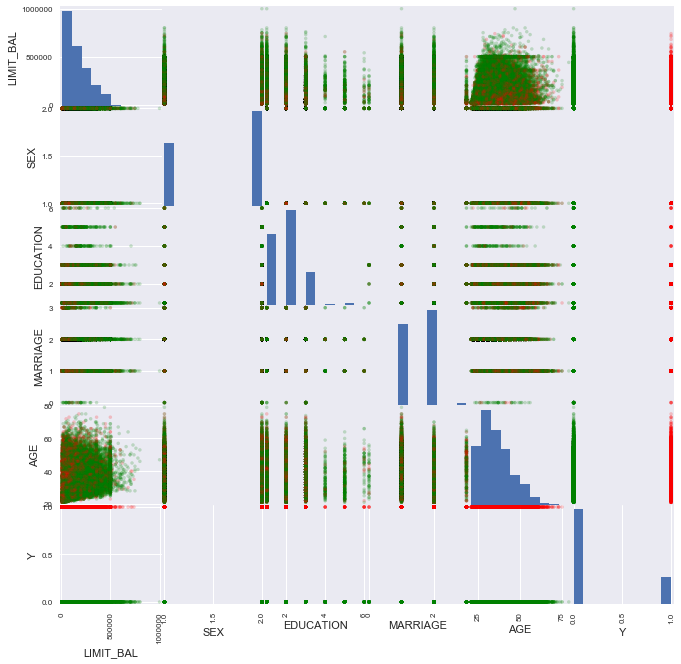

In [14]:
from pandas.plotting import scatter_matrix
# Create new matrix of isolated variables to plot
scatter_df = defaults_df[['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','Y']]
scatter_df = scatter_df.apply(pd.to_numeric)

# define colors list, to be used to plot survived either red (=1) or green (=0)
colors=['green','red']
print(scatter_df.head())
scatter_matrix(scatter_df, alpha=0.2, figsize=(11,11), c=scatter_df.Y.apply(lambda x:colors[x]))

These scatter plots are rather noisy and not really formatted to display information that well. I have looked for a 'jitter' option within pandas plotting to allow for the density of the points to be displayed, rather than just a single point. For example, we cannot infer anything about the relation between education and defaulting with the current information, as each dot is superimposed over another, distorting any information that might be relayed easily here. As well, it would be nice for the categories to have space around the edges so that readers don't confuse categories and their distributions. I know how to do this in ggplot for R, but am still relatively new to plotting in Python, so I'll experiment with packages to achieve these goals later.

For now, I'll plot a correlation matrix to see if we might have any confounding independent variables.

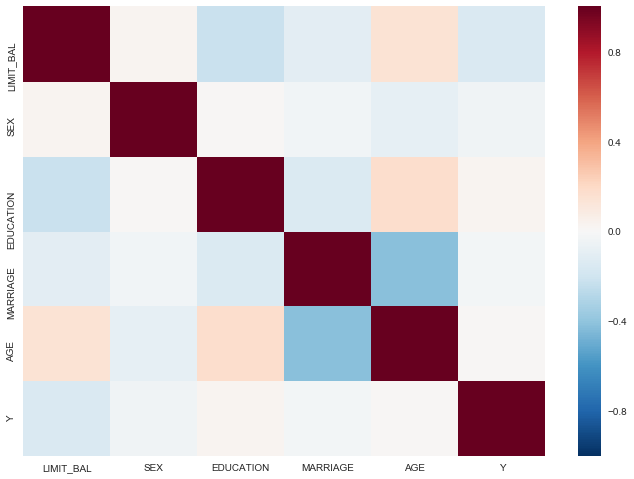

In [15]:
# calculate the correlation matrix
corr = scatter_df.corr()

fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 8.27)
# plot the heatmap
sns.heatmap(corr, ax=ax)

None of the variables are very strongly correlated, but this dataset also contains a plethora of categorical variables. Usually, tables or other discrete metrics are better at observing correlated categorical data, but I will forego this step in favor of plotting education against the dependent variable.

## Education and Defaults
This last part of the data story will look at how education plays a chance in defaults. I chose education as it very generally categorizes people across age, gender, and marriage status.

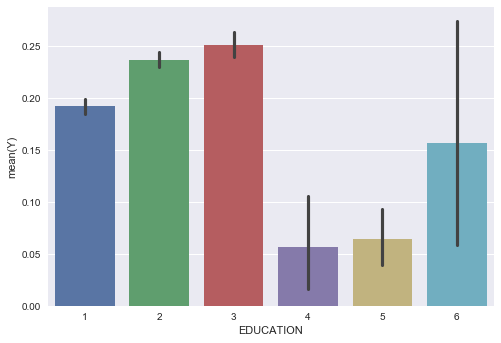

In [16]:
sns.barplot(x="EDUCATION", y="Y", data=scatter_df)

Looks like the mean amount of defaults is higher for education level 3. This bar chart does not account for the samples size of each of these subsets of the population. While I could make more visualizations that portray the rate of default as a function of sample size, education, gender, or marital status, this doesn't provide a satisfying answer about a quantifiable difference. 

# Data Story Conclusion
We've used coordinate plots extensively to see time series relationships of Taiwan credit card customers' debt and payment histories. From these graphical representations, we were able to see that the average debt was increasing while average payment was low and cyclical. 

If we were to use time series analysis to understand this trend and how much debt each person would have in a month, I believe there would be too much noise and variability among customers to accurately do this. Instead, I will resort to creating classification algorithms that take each variable and category into account for a model that can classify to a degree of accuracy whether a person will default in October of 2005. The next thing will be to apply inferential statistics to these findings to test hypotheses about relationships in the data, such as the whether less-educated people are more likely to default on their next payment.

# 3. Inferential Statistics of Taiwan Credit Users
So far, we have cleaned and assessed the data within the Taiwan Credit dataset. We examined the datasets relationships among variables, as well as trends among all of the customers, discovering the data was relatively clean enough to use to create a prediction model and that there were interesting trends in credit user behavior over time. Now I'll use hypothesis testing to find relationships between certain customers and rates of default.

I will focus on education level and determine if there is a statistically significant difference in the rates of default by using a Chi-Square test. I will then look to see if there is a statistical difference between certain groups.

## Chi-Square Tests
To see whether education level makes a difference in the rate of defaults, I will test the null hypothesis that every education group has an equal rate of defaulting on their next payment. I chose to use a Chi-square test because of its ability to deal with data binned into proportions. The basic premise of the Chi-square test is to test the difference between expected and observed values, and if the difference is statistically significant.

In [17]:
# Chi-square
# Create the contingency table
edu_default = pd.crosstab(index=scatter_df["EDUCATION"], 
                           columns=scatter_df["Y"])
edu_default.index= ["graduate","university","secondary","other","5","6"]
chi2, p, dof, ex = stats.chi2_contingency(edu_default)
print(chi2)
print(p)

159.185125405
1.4764557605e-32


With a p-value of 1.4x10^-32, we can see that there must be a difference between education groups. I included in the original analysis the outlier numbers, 5 and 6, both of which do not have an explanation and small sample sizes. I will remove them to make a more accurate assessment of the p-value between education classes provided.

In [18]:
stats_df = scatter_df[(scatter_df.EDUCATION != 5) & (scatter_df.EDUCATION != 6)]
edu_default = pd.crosstab(index=stats_df["EDUCATION"], 
                           columns=stats_df["Y"])
edu_default.index= ["graduate","university","secondary","other"]
chi2, p, dof, ex = stats.chi2_contingency(edu_default)
print(chi2)
print(p)

116.859911535
3.66129962956e-25


There is still significance. Good, that means we can reject the null hyptohesis that a difference in default rate among educational groups is due to random chance. From the bar chart, it looks like the first three classes of education are relatively similar in their rates of default. Let's perform a Chi-square test on those three variables to see if there is statistical difference among them.

In [19]:
educated_df = scatter_df[(scatter_df.EDUCATION != 5) & (scatter_df.EDUCATION != 6) & (scatter_df.EDUCATION != 4)]
edu2_default = pd.crosstab(index=educated_df["EDUCATION"], 
                           columns=educated_df["Y"])
edu2_default.index= ["graduate","university","secondary"]
chi2, p, dof, ex = stats.chi2_contingency(edu_default)
print(chi2)
print(p)

116.859911535
3.66129962956e-25


They are still significantly different. A little obvious from the error bars on the means from the bar chart. Instead of comparing each education class individually, I'll simply calculate the 95% Confidence Interval (CI) for each class of educated people. Using the CI calculations, we can see if there is any overlap between the classes.

In [20]:
graduate_df = scatter_df[scatter_df.EDUCATION == 1]
college_df = scatter_df[scatter_df.EDUCATION == 2]
secondary_df = scatter_df[scatter_df.EDUCATION == 3]
other_df = scatter_df[scatter_df.EDUCATION == 4]
edu_default

Y,0,1
graduate,8549,2036
university,10700,3330
secondary,3680,1237
other,116,7


In [21]:
# odds of default for each education group
grad_def_odds = 2036/8549
univer_def_odds = 3330/10700
second_def_odds = 1237/3680
other_def_odds = 7/116

# Odds Ratios between groups
grad_uni_OR = grad_def_odds/univer_def_odds
grad_second_OR = grad_def_odds/second_def_odds
grad_other_OR = grad_def_odds/other_def_odds
uni_second_OR = univer_def_odds/second_def_odds
uni_other_OR = univer_def_odds/other_def_odds
second_other_OR = second_def_odds/other_def_odds

# SE for each OR
SE_grad_uni = np.sqrt((1/edu_default.iloc[0,0]) + (1/edu_default.iloc[0,1]) + (1/edu_default.iloc[1,0]) + (1/edu_default.iloc[1,1]))
SE_grad_second = np.sqrt((1/edu_default.iloc[0,0]) + (1/edu_default.iloc[0,1]) + (1/edu_default.iloc[2,0]) + (1/edu_default.iloc[2,1]))
SE_grad_other = np.sqrt((1/edu_default.iloc[0,0]) + (1/edu_default.iloc[0,1]) + (1/edu_default.iloc[3,0]) + (1/edu_default.iloc[3,1]))
SE_uni_second = np.sqrt((1/edu_default.iloc[1,0]) + (1/edu_default.iloc[1,1]) + (1/edu_default.iloc[2,0]) + (1/edu_default.iloc[2,1]))
SE_uni_other = np.sqrt((1/edu_default.iloc[1,0]) + (1/edu_default.iloc[1,1]) + (1/edu_default.iloc[3,0]) + (1/edu_default.iloc[3,1]))
SE_second_other = np.sqrt((1/edu_default.iloc[2,0]) + (1/edu_default.iloc[2,1]) + (1/edu_default.iloc[3,0]) + (1/edu_default.iloc[3,1]))

# 95% CI for each OR
grad_uni_CI_Lower = np.exp(np.log(grad_uni_OR) - 1.96*SE_grad_uni)
grad_uni_CI_Upper = np.exp(np.log(grad_uni_OR) + 1.96*SE_grad_uni)
print('Graduate and University OR CI:', grad_uni_CI_Lower, grad_uni_CI_Upper)
print('')
grad_second_CI_Lower = np.exp(np.log(grad_second_OR) - 1.96*SE_grad_second)
grad_second_CI_Upper = np.exp(np.log(grad_second_OR) + 1.96*SE_grad_second)
print('Graduate and Secondary OR CI:', grad_second_CI_Lower, grad_second_CI_Upper)
print('')
grad_other_CI_Lower = np.exp(np.log(grad_other_OR) - 1.96*SE_grad_other)
grad_other_CI_Upper = np.exp(np.log(grad_other_OR) + 1.96*SE_grad_other)
print('Graduate and Other OR CI:', grad_other_CI_Lower, grad_other_CI_Upper)
print('')
uni_second_CI_Lower = np.exp(np.log(uni_second_OR) - 1.96*SE_uni_second)
uni_second_CI_Upper = np.exp(np.log(uni_second_OR) + 1.96*SE_uni_second)
print('University and Secondary OR CI:', uni_second_CI_Lower, uni_second_CI_Upper)
print('')
uni_other_CI_Lower = np.exp(np.log(uni_other_OR) - 1.96*SE_uni_other)
uni_other_CI_Upper = np.exp(np.log(uni_other_OR) + 1.96*SE_uni_other)
print('University and Other OR CI:', uni_other_CI_Lower, uni_other_CI_Upper)
print('')
second_other_CI_Lower = np.exp(np.log(second_other_OR) - 1.96*SE_second_other)
second_other_CI_Upper = np.exp(np.log(second_other_OR) + 1.96*SE_second_other)
print('Secondary and Other OR CI:', second_other_CI_Lower, second_other_CI_Upper)
print("")

Graduate and University OR CI: 0.719214977405 0.814226585777

Graduate and Secondary OR CI: 0.65367999971 0.76791995631

Graduate and Other OR CI: 1.83765094096 8.47582127284

University and Secondary OR CI: 0.858734868565 0.998201118424

University and Other OR CI: 2.40267517214 11.0699522971

Secondary and Other OR CI: 2.59064383314 11.9772179062



## Odds Ratio Analysis
Besides the association between university and secondary educated customers, the odds ratio indicate that many of the compared groups have highly different rates of default, with the 'other' group having the smallest rate and the 'graduate' group having the lowest rate of all the educated groups. The difference in default rates between university and secondary is very slim, which may suggest that they can be grouped together for future analysis.

We have seen differnce that education makes in the likelihood of defaulting on a new payment. While the anlayis was informative, and could provide useful information in the feature engineering process, we still do not have a model that can predict whether a customer is probable to default in the next month or not.

# 4. Basic Logistic Regression and Evaluation
I'll begin building a classification model of whether a customer will default on their next payment by building a base-line logistic regression model using default settings from sklearn. Once trained, I will test its accuracy, precision, and recall measurements. Recall will be the most important metric for this problem since the dataset is imbalanced, since most (about 78%) of the results are from the '0', non-default, class. Recall, or the true positive rate, will be the most important metric to adjust, since the damage done to credit card companies is most severe from not predicting customers who will default and the damage done by predicting a false positive is annoying to the customer, but much less severe in terms of consequences.

Now, to train a logistic regression model with default parameters.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create X and Y objects for clarity
X = clf_df.drop('Y', axis=1)
Y = clf_df.Y

# Split the data into a training and test set - 25% is testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.20, random_state=5)

# Ensuring (X_train, y_train) and (X_test, y_test) are correct
print("Ensuring the training set matrices are of equal size: ", len(Xtrain) == len(ytrain))
print("Ensuring the testing set matrices are of equal size: ", len(ytest) == len(Xtest))
print("Ensuring the train_test_split sums to origninal Length: ", (len(ytest) + len(ytrain)) == len(Y))
# Check ratio of classes in the ytrain and ytest datasets
print("Fraction of the amount of minority class in training set: %.3f" % (len(ytrain[ytrain==1])/len(ytrain)))
print("Fraction of the amount of minority class in testing set: %.3f" % (len(ytest[ytest==1])/len(ytest)))
print("Fraction of the amount of minority class in original dataset: %.3f" % (len(Y[Y==1])/len(Y)))

Ensuring the training set matrices are of equal size:  True
Ensuring the testing set matrices are of equal size:  True
Ensuring the train_test_split sums to origninal Length:  True
Fraction of the amount of minority class in training set: 0.222
Fraction of the amount of minority class in testing set: 0.217
Fraction of the amount of minority class in original dataset: 0.221


We have thoroughly ensured that the test_train_split returned the same fraction of the minority class as is in the parent dataset. Now, I will train a logistic regression model on the Xtrain and ytrain datasets, knowing that they are accurate.

In [23]:
# Creating model
clf = LogisticRegression()
clf.fit(Xtrain, ytrain)

# Print the accuracy and recall from the testing data. Table values.
print('Accuracy Score:', accuracy_score(clf.predict(Xtest), ytest))
target_names = ['0', '1']
print(classification_report(ytest, clf.predict(Xtest), target_names=target_names))

Accuracy Score: 0.78342780927
             precision    recall  f1-score   support

          0       0.78      1.00      0.88      4699
          1       0.00      0.00      0.00      1299

avg / total       0.61      0.78      0.69      5998



/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



We could look at the accuracy and think that 78% is not terrible, a decent start, but reviewing recall shows a large discrepancy between precition of the non-default and default classes. What the default model did was train to maximize accuracy, and by predicting all of the 0-class correctly, it did pretty well to accomplish this goal. However, this completely misses the problem of predicting customers who will default, as is indicated by a recall score of 0 for the default class.

Before I move on to techniques to deal with imbalanced data, I'll try and tune the hyperparameters for both l1 and l2 logistic regression before moving on.

## 5. GridsearchCV to Optimize L1 and L2 Logistic Regression And Evaluation
Will use GridsearchCV from sklearn to find the optimal values of the regularization parameter 'C', according to 'L1' and 'L2' norms. Sklearn's GridsearchCV is able to search for the optimal hyperparameters for both L1 and L2 logistic regression. My expectation is that L2 regression will work better than L1 regularization, as L1 typically works better for data that is sparse, which is not the case from our data, as indicated from the inferential statistics section performed on the data.

I will be optimizing the parameters against accuracy and recall, of which I expect each optimal value to be different.

In [24]:
from sklearn.model_selection import GridSearchCV
parameters_l1 = {'penalty':['l1'], 'C': np.logspace(-4, 2, 30)}
parameters_l2 = {'penalty':['l2'], 'C': np.logspace(-4, 2, 30)}

scores = ['accuracy', 'recall']

clf1 = LogisticRegression() # Do not change this.

for score in scores:
    print("# Tuning hyper-parameters for l1 %s" % score)
    print("")
    clf_opt = GridSearchCV(clf1, parameters_l1, cv=5, 
                           scoring=score)
    clf_opt.fit(Xtrain, ytrain)
    print(clf_opt.best_estimator_, "\n",
          clf_opt.best_params_, "\n",
          clf_opt.best_score_)
    print("")
    print("# Tuning hyper-parameters for l2 %s" % score)
    print("")
    clf_opt = GridSearchCV(clf1, parameters_l2, cv=5, 
                           scoring=score)
    clf_opt.fit(Xtrain, ytrain)
    print(clf_opt.best_estimator_, "\n",
          clf_opt.best_params_, "\n",
          clf_opt.best_score_)

# Tuning hyper-parameters for l1 accuracy

LogisticRegression(C=0.85316785241728055, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l1', 'C': 0.85316785241728055} 
 0.818909454727

# Tuning hyper-parameters for l2 accuracy

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l2', 'C': 0.0001} 
 0.777472069368
# Tuning hyper-parameters for l1 recall

LogisticRegression(C=0.52983169062837077, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,


We now have the optimal gridsearchCV parameters. What are their respective recall scores?

In [25]:
clf_opt_recall_L1 = LogisticRegression(penalty='l1', C=0.204335) 
clf_opt_accuracy_L1 = LogisticRegression(penalty='l1', C=0.85316) 

clf_opt_recall_L2 = LogisticRegression(penalty='l2', C=0.0001) 
clf_opt_accuracy_L2 = LogisticRegression(penalty='l2', C=0.0001) 

#Fitting the models
clf_opt_recall_L1.fit(Xtrain, ytrain)
clf_opt_recall_L2.fit(Xtrain, ytrain)

clf_opt_accuracy_L1.fit(Xtrain, ytrain)
clf_opt_accuracy_L2.fit(Xtrain, ytrain)

print('Optimized L1 precision-recall scores')
print('')
print('Optimized Recall')
print(classification_report(ytest, clf_opt_recall_L1.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))
print('Optimized Accuracy')
print(classification_report(ytest, clf_opt_accuracy_L1.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))
print('')
print('Optimized L2 precision-recall scores')
print('')
print('Optimized Recall')
print(classification_report(ytest, clf_opt_recall_L2.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))
print('Optimized Accuracy')
print(classification_report(ytest, clf_opt_accuracy_L2.fit(Xtrain, ytrain).predict(Xtest), target_names=target_names))

Optimized L1 precision-recall scores

Optimized Recall
             precision    recall  f1-score   support

          0       0.84      0.95      0.89      4699
          1       0.68      0.37      0.48      1299

avg / total       0.81      0.82      0.80      5998

Optimized Accuracy
             precision    recall  f1-score   support

          0       0.85      0.95      0.90      4699
          1       0.68      0.37      0.48      1299

avg / total       0.81      0.83      0.81      5998


Optimized L2 precision-recall scores

Optimized Recall


/Users/vincent_zaballa/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



             precision    recall  f1-score   support

          0       0.78      1.00      0.88      4699
          1       0.00      0.00      0.00      1299

avg / total       0.61      0.78      0.69      5998

Optimized Accuracy
             precision    recall  f1-score   support

          0       0.78      1.00      0.88      4699
          1       0.00      0.00      0.00      1299

avg / total       0.61      0.78      0.69      5998



We can see that, while there is a difference in the optimal values for accuracy and recall, the parameter values differ by less than a thousandth. The bigger difference here is between L1 and L2 regularization, of which, L1 performed much better than L2. Even when optimized for recall, L2 was not able to return a satisfactory result. This is not to say that L1 logistic regression returned a satisfactory result, as a recall of 0.34 for defaults can still be considered bad, but that it is much better than 0.

# 6. Resampling: Oversampling and Undersampling Methods on Logistic Regression
There is an imbalance in the dataset that cannot be solved by simply optimizing the penalty parameters of L1-logistic regression. Instead, I will need to either under-sample or over-sample the dataset to balance the two. According to the rules of thumb listed below, I can choose from under-sampling or over-sampling to balance the dataset. I can do both and compare their Accuracy and precision-recall metric in order to determine which method improves the model the most. Additionally, I will experiment with random and non-random sampling schemes for over-sampling and under-sampling. From here on I will refer to the class with more elements as the "majority class" and the one with less as the "minority class". 

Some Rules of Thumb:

- Consider under-sampling of the majority class when there is plenty of data (tens- or hundreds of thousands of instances or more)

- Consider over-sampling of the minority class when you have a paucity of data (tens of thousands of records or less)

- Consider random and non-random (e.g. stratified) sampling schemes.

- Consider different resampling ratios (e.g. you don’t have to target a 1:1 ratio in a binary classification problem, try other ratios)

I will oversample the minority class so both classes have the same size. I will use SMOTE, implemented by the imbalanced-learn package, which works as follows:

- Finding the k-nearest-neighbors for minority class observations (finding similar observations)

- Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observation.

## Undersampling

In [26]:
from imblearn.under_sampling import RandomUnderSampler
# Reminder: Xtrain, Xtest, ytrain, ytest

# Undersampling with imblearn
rus = RandomUnderSampler(random_state = 12, ratio=1.0)
X_us, Y_us = rus.fit_sample(X, Y)

# Creating training/testing split for undersampled dataset
X_train_us, X_test_us, Y_train_us, Y_test_us = train_test_split(X_us, Y_us, test_size=0.20, random_state=5,
                                                stratify=Y_us)

# Check ratio of classes in the ytrain and ytest datasets
print("Fraction of the amount of minority class in training set: %.3f" % (len(Y_train_us[Y_train_us==1])/len(Y_train_us)))
print("Fraction of the amount of minority class in testing set: %.3f" % (len(Y_test_us[Y_test_us==1])/len(Y_test_us)))
print("Fraction of the amount of minority class in original dataset: %.3f" % (len(Y[Y==1])/len(Y)))

Fraction of the amount of minority class in training set: 0.500
Fraction of the amount of minority class in testing set: 0.500
Fraction of the amount of minority class in original dataset: 0.221


We can see that the fraction of positive to negative outcomes is completely equal here. This was meant to verify that I properly under-sampled the dataset and preserved an equal ratio in the training and test datasets.

In [27]:
# GridsearchCV
parameters_l1 = {'penalty':['l1'], 'C': np.logspace(-4, 2, 30)}
parameters_l2 = {'penalty':['l2'], 'C': np.logspace(-4, 2, 30)}

scores = ['accuracy', 'recall']

# out of the box logistic regression
clf_smpld = LogisticRegression()
clf_smpld.fit(X_train_us, Y_train_us)

for score in scores:
    print("# Tuning hyper-parameters for l1 %s" % score)
    print("")
    
    clf_opt_under_smpld = GridSearchCV(clf1, parameters_l1, cv=5, #still using clf1 from first cell
                           scoring=score)
    clf_opt_under_smpld.fit(X_train_us, Y_train_us)
    
    print(clf_opt_under_smpld.best_estimator_, "\n",
          clf_opt_under_smpld.best_params_, "\n",
          clf_opt_under_smpld.best_score_)
    print("")
    print("# Tuning hyper-parameters for l2 %s" % score)
    print("")
    
    clf_opt_under_smpld = GridSearchCV(clf1, parameters_l2, cv=5, 
                           scoring=score)
    clf_opt_under_smpld.fit(X_train_us, Y_train_us)
    
    print(clf_opt_under_smpld.best_estimator_, "\n",
          clf_opt_under_smpld.best_params_, "\n",
          clf_opt_under_smpld.best_score_)

# Tuning hyper-parameters for l1 accuracy

LogisticRegression(C=0.32903445623126676, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l1', 'C': 0.32903445623126676} 
 0.704436281435

# Tuning hyper-parameters for l2 accuracy

LogisticRegression(C=0.85316785241728055, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l2', 'C': 0.85316785241728055} 
 0.632570405953
# Tuning hyper-parameters for l1 recall

LogisticRegression(C=0.0017433288221999873, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penal

In [28]:
# Creating new models
clf_under_smpld_accur_l1 = LogisticRegression(penalty='l1', C=0.32903)
clf_under_smpld_accur_l2 = LogisticRegression(penalty='l2', C=5.73615)

clf_under_smpld_recall_l1 = LogisticRegression(penalty='l1', C=0.001743)
clf_under_smpld_recall_l2 = LogisticRegression(penalty='l2', C=23.95027)

# Fitting the models
clf_under_smpld_accur_l1.fit(X_train_us, Y_train_us)
clf_under_smpld_accur_l2.fit(X_train_us, Y_train_us)

clf_under_smpld_recall_l1.fit(X_train_us, Y_train_us)
clf_under_smpld_recall_l2.fit(X_train_us, Y_train_us)

# Summary of precision-recall metric for all models
print('\nUndersampled precision-recall metrics\n')
print("\nPrecision-Recall Metrics of Non-Optimized Logistic Regression\n")
print(classification_report(Y_test_us, clf_smpld.fit(X_train_us, Y_train_us).predict(X_test_us),
                            target_names=target_names))
print('')
print("Accuracy Optimized Logistic Regression\n")
print("l1")
print(classification_report(Y_test_us, clf_under_smpld_accur_l1.fit(X_train_us, Y_train_us).predict(X_test_us),
                            target_names=target_names))
print("l2")
print(classification_report(Y_test_us, clf_under_smpld_accur_l2.fit(X_train_us, Y_train_us).predict(X_test_us),
                            target_names=target_names))
print('')
print("Recall Optimized Logistic Regression\n")
print("l1")
print(classification_report(Y_test_us, clf_under_smpld_recall_l1.fit(X_train_us, Y_train_us).predict(X_test_us),
                            target_names=target_names))
print("l2")
print(classification_report(Y_test_us, clf_under_smpld_recall_l2.fit(X_train_us, Y_train_us).predict(X_test_us),
                            target_names=target_names))


Undersampled precision-recall metrics


Precision-Recall Metrics of Non-Optimized Logistic Regression

             precision    recall  f1-score   support

          0       0.64      0.54      0.59      1327
          1       0.60      0.69      0.64      1328

avg / total       0.62      0.62      0.61      2655


Accuracy Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.68      0.83      0.75      1327
          1       0.78      0.60      0.68      1328

avg / total       0.73      0.72      0.71      2655

l2
             precision    recall  f1-score   support

          0       0.65      0.50      0.57      1327
          1       0.60      0.73      0.66      1328

avg / total       0.62      0.62      0.61      2655


Recall Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.66      0.59      0.62      1327
          1       0.63      0.70      0.66      1328

a

### Note: Accuracy and Recall Optimized GridsearchCV
As expected, there is a change in recall score when optimized for recall as opposed to accuracy. However, it's interesting to note that the recall-optimized L1 has a lower overall recall than accuracy-optimized L1 logistic regression. The recall would be higher for the recall-optimized L1 logistic regression, but it is not. Further investigation needs to be done with a graphical interpretation of the values. I will plot these on a precision-recall curve, later.

## Undersampling Result Interpretation
As mentioned, there was not a difference between optimizing for accuracy and recall. There was a large difference in recall between L1 and L2 optimized results. The L1 logistic regression has a better score for predicting the non-default class, whereas the L2 logistic regression is better at predicting for the default (Y=1) class. The default logistic regression algorithm didn't do too bad, but that's mainly because it is using L2 regularization under the hood and the optimal lambda value of C=1. I will leave out the default parameter from here on out, as I just wanted to show that it can return a decent accuracy or recall measurement.

## Oversampling
Now that we've seen some results for undersampling the majority class, let's take a look at oversampling the minority class. This time, I am just going to optimize the parameters on the 'recall' measurement and leave out the default logistic regression value.

In [29]:
from imblearn.over_sampling import SMOTE
# Smote oversampling
sm = SMOTE(random_state=12, ratio = 1.0) # ratio = 1 means equal classes. This can be tweaked.
X_os, Y_os = sm.fit_sample(X, Y)

# Creating training/testing split for undersampled dataset
X_train_os, X_test_os, Y_train_os, Y_test_os = train_test_split(X_os, Y_os, test_size=0.20, random_state=5,
                                                stratify=Y_os)

# Check ratio of classes in the ytrain and ytest datasets
print("Fraction of the amount of minority class in training set: %.3f" % (len(Y_train_os[Y_train_os==1])/len(Y_train_os)))
print("Fraction of the amount of minority class in testing set: %.3f" % (len(Y_test_os[Y_test_os==1])/len(Y_test_os)))
print("Fraction of the amount of minority class in original dataset: %.3f" % (len(Y[Y==1])/len(Y)))

Fraction of the amount of minority class in training set: 0.500
Fraction of the amount of minority class in testing set: 0.500
Fraction of the amount of minority class in original dataset: 0.221


We can see that the ratio of minority class to majority class is once again equalized here. Now to train a model with the oversampled dataset.

In [30]:
# GridsearchCV
parameters_l1 = {'penalty':['l1'], 'C': np.logspace(-4, 2, 30)}
parameters_l2 = {'penalty':['l2'], 'C': np.logspace(-4, 2, 30)}

scores = ['accuracy', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for l1 %s" % score)
    print("")
    
    clf_opt_over_smpld = GridSearchCV(clf1, parameters_l1, cv=5, 
                           scoring=score)
    clf_opt_over_smpld.fit(X_train_os, Y_train_os)
    
    print(clf_opt_over_smpld.best_estimator_, "\n",
          clf_opt_over_smpld.best_params_, "\n",
          clf_opt_over_smpld.best_score_)
    print("")
    print("# Tuning hyper-parameters for l2 %s" % score)
    print("")
    
    clf_opt_over_smpld = GridSearchCV(clf1, parameters_l2, cv=5, 
                           scoring=score)
    clf_opt_over_smpld.fit(X_train_os, Y_train_os)
    
    print(clf_opt_over_smpld.best_estimator_, "\n",
          clf_opt_over_smpld.best_params_, "\n",
          clf_opt_over_smpld.best_score_)

# Tuning hyper-parameters for l1 accuracy

LogisticRegression(C=0.52983169062837077, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l1', 'C': 0.52983169062837077} 
 0.730380085653

# Tuning hyper-parameters for l2 accuracy

LogisticRegression(C=0.20433597178569418, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l2', 'C': 0.20433597178569418} 
 0.644566381156
# Tuning hyper-parameters for l1 recall

LogisticRegression(C=0.00041753189365604002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, pena

In [31]:
# Creating new models
clf_over_smpld_accur_l1 = LogisticRegression(penalty='l1', C=0.52983)
clf_over_smpld_accur_l2 = LogisticRegression(penalty='l2', C=0.20436)

clf_over_smpld_recall_l1 = LogisticRegression(penalty='l1', C=0.00042)
clf_over_smpld_recall_l2 = LogisticRegression(penalty='l2', C=0.04894)

#Fitting models
clf_over_smpld_accur_l1.fit(X_train_os, Y_train_os)
clf_over_smpld_accur_l2.fit(X_train_os, Y_train_os)

clf_over_smpld_recall_l1.fit(X_train_os, Y_train_os)
clf_over_smpld_recall_l2.fit(X_train_os, Y_train_os)

# Summary of precision-recall metric for all models
print('\nOversampled precision-recall metrics\n')
print("Accuracy Optimized Logistic Regression\n")
print("l1")
print(classification_report(Y_test_os, clf_over_smpld_accur_l1.fit(X_train_os, Y_train_os).predict(X_test_os),
                            target_names=target_names))
print("l2")
print(classification_report(Y_test_os, clf_over_smpld_accur_l2.fit(X_train_os, Y_train_os).predict(X_test_os),
                            target_names=target_names))
print('')
print("Recall Optimized Logistic Regression\n")
print("l1")
print(classification_report(Y_test_os, clf_over_smpld_recall_l1.fit(X_train_os, Y_train_os).predict(X_test_os),
                            target_names=target_names))
print("l2")
print(classification_report(Y_test_os, clf_over_smpld_recall_l2.fit(X_train_os, Y_train_os).predict(X_test_os),
                            target_names=target_names))


Oversampled precision-recall metrics

Accuracy Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.69      0.84      0.76      4670
          1       0.80      0.62      0.70      4670

avg / total       0.75      0.73      0.73      9340

l2
             precision    recall  f1-score   support

          0       0.66      0.52      0.58      4670
          1       0.60      0.73      0.66      4670

avg / total       0.63      0.63      0.62      9340


Recall Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.67      0.52      0.58      4670
          1       0.61      0.74      0.67      4670

avg / total       0.64      0.63      0.62      9340

l2
             precision    recall  f1-score   support

          0       0.66      0.51      0.57      4670
          1       0.60      0.74      0.66      4670

avg / total       0.63      0.62      0.62      9340



We can see that oversampling performed slightly better than undersampling in improving the recall score for the minority class of the dataset. This could be because the oversampling technique narrowed the distribution of the minority class, making it easier to train a model that could identify it. Future work will need to compare different oversampling techniques to improve model performance.

## Scaling and Comparing Results
I'll implement scaling with under and over-sampling methods at once, only optimizing for recall in all of the cases, and compare the results afterwards.

In [32]:
# Scaling X and comparing results
X2 = (X - X.mean()) / X.std()

# Undersampling with imblearn
rus = RandomUnderSampler(random_state = 12, ratio=1.0)
X_us2, Y_us2 = rus.fit_sample(X2, Y)

# Creating training/testing split for undersampled dataset
X_train_us2, X_test_us2, Y_train_us2, Y_test_us2 = train_test_split(X_us2, Y_us2, test_size=0.20, random_state=5,
                                                    stratify=Y_us2)

# GridsearchCV
parameters_l1 = {'penalty':['l1'], 'C': np.logspace(-4, 2, 30)}
parameters_l2 = {'penalty':['l2'], 'C': np.logspace(-4, 2, 30)}

scores = ['accuracy', 'recall']

# out of the box logistic regression
clf_smpld = LogisticRegression()
clf_smpld.fit(X_train_us2, Y_train_us2)

for score in scores:
    print("# Tuning hyper-parameters for l1 %s" % score)
    print("")
    
    clf_opt_under_smpld = GridSearchCV(clf1, parameters_l1, cv=5, 
                           scoring=score)
    clf_opt_under_smpld.fit(X_train_us2, Y_train_us2)
    
    print(clf_opt_under_smpld.best_estimator_, "\n",
          clf_opt_under_smpld.best_params_, "\n",
          clf_opt_under_smpld.best_score_)
    print("")
    print("# Tuning hyper-parameters for l2 %s" % score)
    print("")
    
    clf_opt_under_smpld = GridSearchCV(clf1, parameters_l2, cv=5, 
                           scoring=score)
    clf_opt_under_smpld.fit(X_train_us2, Y_train_us2)
    
    print(clf_opt_under_smpld.best_estimator_, "\n",
          clf_opt_under_smpld.best_params_, "\n",
          clf_opt_under_smpld.best_score_)

# Tuning hyper-parameters for l1 accuracy

LogisticRegression(C=0.32903445623126676, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l1', 'C': 0.32903445623126676} 
 0.70434209287

# Tuning hyper-parameters for l2 accuracy

LogisticRegression(C=0.00041753189365604002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l2', 'C': 0.00041753189365604002} 
 0.707450315532
# Tuning hyper-parameters for l1 recall

LogisticRegression(C=3.5622478902624439, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, pen

In [33]:
# Creating new models
clf_under_smpld_accur_l1 = LogisticRegression(penalty='l1', C=0.32903)
clf_under_smpld_accur_l2 = LogisticRegression(penalty='l2', C=0.000417)

clf_under_smpld_recall_l1 = LogisticRegression(penalty='l1', C=100.0)
clf_under_smpld_recall_l2 = LogisticRegression(penalty='l2', C=0.0001)

# Fitting the models
clf_under_smpld_accur_l1.fit(X_train_us2, Y_train_us2)
clf_under_smpld_accur_l2.fit(X_train_us2, Y_train_us2)

clf_under_smpld_recall_l1.fit(X_train_us2, Y_train_us2)
clf_under_smpld_recall_l2.fit(X_train_us2, Y_train_us2)

# Summary of precision-recall metric for all models
print('\nUndersampled precision-recall metrics\n')
print("\nPrecision-Recall Metrics of Non-Optimized Logistic Regression\n")
print(classification_report(Y_test_us2, clf_smpld.fit(X_train_us2, Y_train_us2).predict(X_test_us2),
                            target_names=target_names))
print('')
print("Accuracy Optimized Logistic Regression\n")
print("l1")
print(classification_report(Y_test_us2, clf_under_smpld_accur_l1.fit(X_train_us2, Y_train_us2).predict(X_test_us2),
                            target_names=target_names))
print("l2")
print(classification_report(Y_test_us2, clf_under_smpld_accur_l2.fit(X_train_us2, Y_train_us2).predict(X_test_us2),
                            target_names=target_names))
print('')
print("Recall Optimized Logistic Regression\n")
print("l1")
print(classification_report(Y_test_us2, clf_under_smpld_recall_l1.fit(X_train_us2, Y_train_us2).predict(X_test_us2),
                            target_names=target_names))
print("l2")
print(classification_report(Y_test_us2, clf_under_smpld_recall_l2.fit(X_train_us2, Y_train_us2).predict(X_test_us2),
                            target_names=target_names))


Undersampled precision-recall metrics


Precision-Recall Metrics of Non-Optimized Logistic Regression

             precision    recall  f1-score   support

          0       0.68      0.83      0.74      1327
          1       0.78      0.60      0.68      1328

avg / total       0.73      0.71      0.71      2655


Accuracy Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.68      0.83      0.74      1327
          1       0.78      0.60      0.68      1328

avg / total       0.73      0.72      0.71      2655

l2
             precision    recall  f1-score   support

          0       0.68      0.83      0.75      1327
          1       0.78      0.60      0.68      1328

avg / total       0.73      0.72      0.71      2655


Recall Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.68      0.83      0.74      1327
          1       0.78      0.60      0.68      1328

a

In [34]:
# Smote oversampling
sm = SMOTE(random_state=12, ratio = 1.0) # ratio = 1 means equal classes. This can be tweaked.
X_os2, Y_os2 = sm.fit_sample(X2, Y)

# Creating training/testing split for undersampled dataset
X_train_os2, X_test_os2, Y_train_os2, Y_test_os2 = train_test_split(X_os2, Y_os2, test_size=0.20, random_state=5,
                                                stratify=Y_os2)

# GridsearchCV
parameters_l1 = {'penalty':['l1'], 'C': np.logspace(-4, 2, 30)}
parameters_l2 = {'penalty':['l2'], 'C': np.logspace(-4, 2, 30)}

scores = ['accuracy', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for l1 %s" % score)
    print("")
    
    clf_opt_over_smpld = GridSearchCV(clf1, parameters_l1, cv=5, 
                           scoring=score)
    clf_opt_over_smpld.fit(X_train_os2, Y_train_os2)
    
    print(clf_opt_over_smpld.best_estimator_, "\n",
          clf_opt_over_smpld.best_params_, "\n",
          clf_opt_over_smpld.best_score_)
    print("")
    print("# Tuning hyper-parameters for l2 %s" % score)
    print("")
    
    clf_opt_over_smpld = GridSearchCV(clf1, parameters_l2, cv=5, 
                           scoring=score)
    clf_opt_over_smpld.fit(X_train_os2, Y_train_os2)
    
    print(clf_opt_over_smpld.best_estimator_, "\n",
          clf_opt_over_smpld.best_params_, "\n",
          clf_opt_over_smpld.best_score_)

# Tuning hyper-parameters for l1 accuracy

LogisticRegression(C=0.32903445623126676, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l1', 'C': 0.32903445623126676} 
 0.705353319058

# Tuning hyper-parameters for l2 accuracy

LogisticRegression(C=0.00016102620275609394, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) 
 {'penalty': 'l2', 'C': 0.00016102620275609394} 
 0.706076017131
# Tuning hyper-parameters for l1 recall

LogisticRegression(C=0.32903445623126676, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, p

In [35]:
# Creating new models
clf_over_smpld_accur_l1 = LogisticRegression(penalty='l1', C=0.32903)
clf_over_smpld_accur_l2 = LogisticRegression(penalty='l2', C=0.00016)

clf_over_smpld_recall_l1 = LogisticRegression(penalty='l1', C=0.329034)
clf_over_smpld_recall_l2 = LogisticRegression(penalty='l2', C=0.588865)

#Fitting models
clf_over_smpld_accur_l1.fit(X_train_os2, Y_train_os2)
clf_over_smpld_accur_l2.fit(X_train_os2, Y_train_os2)

clf_over_smpld_recall_l1.fit(X_train_os2, Y_train_os2)
clf_over_smpld_recall_l2.fit(X_train_os2, Y_train_os2)

# Summary of precision-recall metric for all models
print('\nOversampled precision-recall metrics\n')
print("Accuracy Optimized Logistic Regression\n")
print("l1")
print(classification_report(Y_test_os2, clf_under_smpld_accur_l1.fit(X_train_os2, Y_train_os2).predict(X_test_os2),
                            target_names=target_names))
print("l2")
print(classification_report(Y_test_os2, clf_under_smpld_accur_l2.fit(X_train_os2, Y_train_os2).predict(X_test_os2),
                            target_names=target_names))
print('')
print("Recall Optimized Logistic Regression\n")
print("l1")
print(classification_report(Y_test_os2, clf_under_smpld_recall_l1.fit(X_train_os2, Y_train_os2).predict(X_test_os2),
                            target_names=target_names))
print("l2")
print(classification_report(Y_test_os2, clf_under_smpld_recall_l2.fit(X_train_os2, Y_train_os2).predict(X_test_os2),
                            target_names=target_names))


Oversampled precision-recall metrics

Accuracy Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.66      0.83      0.74      4670
          1       0.78      0.58      0.66      4670

avg / total       0.72      0.71      0.70      9340

l2
             precision    recall  f1-score   support

          0       0.67      0.83      0.74      4670
          1       0.78      0.58      0.67      4670

avg / total       0.72      0.71      0.70      9340


Recall Optimized Logistic Regression

l1
             precision    recall  f1-score   support

          0       0.66      0.83      0.74      4670
          1       0.78      0.58      0.66      4670

avg / total       0.72      0.71      0.70      9340

l2
             precision    recall  f1-score   support

          0       0.67      0.83      0.74      4670
          1       0.78      0.59      0.67      4670

avg / total       0.72      0.71      0.70      9340



In [36]:
from mlxtend.evaluate import lift_score
lift_score(Y_test_os2, clf_opt_over_smpld.predict(X_test_os2))

1.5510319479785131

# Comparison Between Scaled and Original Data
Scaling the variables before training a model seems to normalize the results between L1 and L2 regularization. Generally, all of the models that were scaled performed better at increasing precision while most of the models from the original dataset (all except one) returned a higher recall metric than the scaled models. Since we are trying to maximize the recall for the default class (Y=1), I will continue with the non-scaled models.

Something to think about for the future is assessing what the cost of a false positive is in this case. For example, if someone is labeled as liable to default but does not, how will that affect the bank? This is a common question in large-scale manufacturing, where processes cannot be halted simply because a part might be defective, as that down-time costs the company a great deal of money.

# 7. Conclusions & Summary of Findings
The original goal of this project was to assess the dataset and create a classification model that would maximize the number of default customers predicted. In the process of examining the data, I discovered an imbalance in the response variable that provided problems in predicting for the minority class of data, default customers who I wanted to predict would default on their next payment.

To remedy this case of class imbalance, where about 20% of the response lay within the minority class and the rest in the majority class, I employed resampling techniques to adjust the ratio of minority class to majority class. The undersampling algorithm I used took random samples from the majority class to match the number of samples in the minority class. The oversampling algorithm is known as SMOTE and is a sophisticated method of creating new minority measurements, but has its drawbacks. Both under and over-sampling return improved modeling results for this imbalanced dataset by improving the recall of the minority class. 

I then scaled the data by subtracting the mean amount from each column and dividing by the standard deviation. After scaling, I employed both resampling techniques and optimized for recall, since that clearly returned the maximum recall score for the minority class. The results showed an overall increased precision values for all of the models and for both resampling techniques, but the recall for the minority class stagnated around a value of 0.60, where a value of 0.75 was achieved with non-scaled and oversampled L2 logistic regression. While there are costs associated with lower precision, it is up to the user and model-builder to determine how many false positives are acceptable for the application in question.

To improve models, here are the steps that I would take:
1. Use the current process to compare to different algorithms, such as Naive Bayes, KNN, discriminant bayes, and neural networks.
2. Adjust the classification threshold. Instead of making 50% probability of default, I could shift that threshold up and down to adjust recall and precision rates. In practice, this is useful as precision cannot be ignored, as there are also costs associated with lower precision rates.
3. Adjust the resampling techniques. The package Imblearn provides many different options for undersampling and oversampling, of which I can experiment with new methods to improve precision and recall rates. Do this step in combination with the previous steps.

## Comparison to Parent Study
This project dove into the details of resampling techniques and how they can benefit classification algorithms. I focused on logistic regression models and two resampling techniques to thoroughly examine the benefits of optimizing for accuracy and recall, as well as observing the effect that resampling had on improving model performance. With the process in place for imbalanced data, I can then compare models that have employed resampling and to models that do not need to resample, such as random forest or CART models.

The authors of the original paper focused on predicting the actual probability of default by employing a novel measurement technique. To measure the accuracy of their prediction models, they used a gains chart to measure the increase in prediction capability for each model they used. They used the ratio of the area under the predictive model divided by the area under a perfect model to return a single number for model accuracy. However, this study did not employ resampling methods to improve model performance, as the main goal of their paper was to assess a novel method for assessing the real probability of default.

Since the authors did not use resampling techniques to improve their models, it would be interesting to compare results with updated model predictions. While lift charts are not directly linked to recall, it would be interesting to see how our results compare. Due to time constraints, I will leave construction of lift charts and comparison to the parent paper's results for future work.

This project showed steps on how to deal with imbalanced data and observed improved recall rates for both L1 and L2 regularized logistic regression when resampling was employed. Oversampling performed slightly better than undersampling for improving recall rates of the minority class. Future analysis will dive into why oversampling did better in this case and what other resampling techniques might improve model performance for this particular dataset.

# References
1. Yeh, I-Cheng, and Che-hui Lien. "The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients." Expert Systems with Applications 36.2 (2009): 2473-2480.
2. Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010) 
3. Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay. Scikit-learn: Machine Learning in Python, Journal of Machine Learning Research, 12, 2825-2830 (2011) (publisher link)
4. John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007),DOI:10.1109/MCSE.2007.55
5. Lemaıtre, Guillaume, Fernando Nogueira, and Christos K. Aridas. "Imbalanced-learn: A python toolbox to tackle the curse of imbalanced datasets in machine learning." Journal of Machine Learning Research 18.17 (2017): 1-5.